# Continuous Control
**Michael Santoro - michael.santoro@du.edu**
# Introduction
**TO-DO:**
- Add DDPG Overview
- Add PPO Overview
- Add Approach
    - Get some convergence on a single agent enviroment
    - Work on Multi Agent Enviroment
    

In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent as agent_ddpg
from ppo_agent import Agent as agent_ppo
from unityagents import UnityEnvironment

from easydict import EasyDict as e_dict

seed = 42

In [2]:
env = UnityEnvironment(file_name="reacher_v1\Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()

# DDPG
## Single Agent

### Learning Algorithim
The [Deep Deterministic Policy Gradients (DDPG)](https://arxiv.org/pdf/1509.02971.pdf) Set out to solve continuous control problems. Traditional reinforcement learning algorithms like Q-learning and SARSA are not well-suited for continuous control tasks because they require a discrete action space. DDPG, on the other hand, is an actor-critic algorithm that can handle continuous action spaces, making it a popular choice for solving tasks like robotic control, autonomous driving, and game playing.

### Initial Experiment

Initially the parameters for the algorithim of the single agent are set to the following:
- Actor Learning Rate: $10^{-4}$
- Critic Learning Rate: $10^{-3}$
- Layer 2 Decay: $10^{-2}$
- Discount Factor: $\gamma = 0.99$

Initial Runs Showed an initial loss function of 0.

In [3]:
ddpg_config = e_dict()

ddpg_config.state_size = 33         # enviroment size
ddpg_config.action_size = 4         # action size
ddpg_config.seed = 42

## DDPG Params
ddpg_config.buffer_size = int(1e6)  # replay buffer size
ddpg_config.batch_size = 64         # minibatch size
ddpg_config.gamma = 0.99            # discount factor
ddpg_config.tau = 1e-3              # for soft update of target parameters
ddpg_config.lr_actor = 1e-4         # learning rate of the actor
ddpg_config.lr_critic = 1e-3        # learning rate of the critic
ddpg_config.weight_decay = 1e-2     # L2 weight decay
ddpg_config.loss = 'mae'            # loss functions include 'mae' or 'mse'

## Noise Params
ddpg_config.theta = 0.15
ddpg_config.sigma = 0.2

## Nueral Network Params
ddpg_config.fc1_param = 400
ddpg_config.fc2_param = 300

In [4]:
agent = agent_ddpg(ddpg_config)

In [5]:
def ddpg(n_episodes=150, max_t=300, print_every=50):
    scores_deque = deque(maxlen=print_every)
    actor_loss_deque = deque(maxlen=print_every)
    critic_loss_deque = deque(maxlen=print_every)
    scores = []
    actor_loss_list = []
    critic_loss_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            action = action.astype(np.int32)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            actor_loss, critic_loss = agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        actor_loss_deque.append(actor_loss)
        critic_loss_deque.append(critic_loss)
        scores.append(score)
        actor_loss_list.append(actor_loss)
        critic_loss_list.append(critic_loss)
        print('\rEpisode {}\tAverage Score: {:.2f}\tActor Loss: {:.2f}\tCritic Loss: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(actor_loss_deque), np.mean(critic_loss_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tActor Loss: {:.2f}\tCritic Loss: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(actor_loss_deque), np.mean(critic_loss_deque)))
            
    return scores,actor_loss_list,critic_loss_list

scores, actor_loss, critic_loss = ddpg()



Episode 31	Average Score: 0.13	Actor Loss: -0.00	Critic Loss: 0.00

In [9]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

#### Score Results

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Loss Results

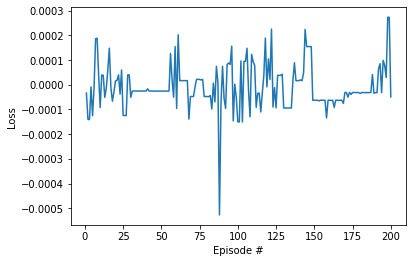

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(actor_loss)+1), actor_loss)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()

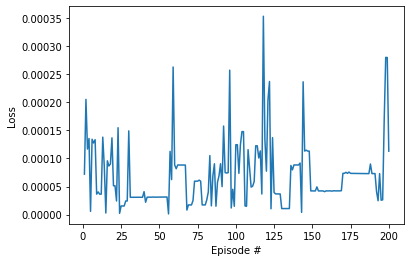

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(critic_loss)+1), critic_loss)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()

## View the Trained Agent Play

In [8]:
env = UnityEnvironment(file_name="reacher_v1\Reacher.exe")

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


In [ ]:


agent = Agent(state_size=33, action_size=4, random_seed=seed)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state) #Select an Action
        action = action.astype(np.int32)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
            
env.close()

c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Plot of Rewards

# Multi Agent

In [2]:
env = UnityEnvironment(file_name="reacher_v2\Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close

## Learning Algorithim

## Plot of Rewards

# Ideas for Future Work

In [ ]:
def ppo(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            action = action.astype(np.int32)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = ppo()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()